# INFORMACIÓN:

- __AUTOR:__ Maximiliano Greco
- __FECHA:__ Agosto-2015
- __PYTHON:__ 3.k



In [1]:
# python 3, compatibilidad:
from __future__ import division, unicode_literals, print_function, absolute_import
import os
from numpy import *
import statsmodels.api as sm
import scipy as sp 
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
import prettyplotlib as ppl

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


In [2]:
# %load code/utils/utiles.py
#!/usr/bin/env


def decimal_to_point(x):
    '''
    Solo en cadenas de texto, si no es una cadena omite la operación.
    Elimina los puntos (.) de miles.
    Reemplaza la coma decimal (",") por el punto decimal (".")
    en una cadena de texto y lo convierte a punto flotante.
    ----------
    ej:
    decimal_to_point('123.456.789,43') == 123456789.43
    '''
    try:
        return float(x.replace('.', '').replace(',', '.'))
    except:
        return float(x)


def romans_to_num(x): # modificar para que no dependa de T
    '''
    Reemplaza los numeros romanos del 1 al 4 por el caracter númerico.
    ----------
    ej:
    romans_to_num('II') == 2
    '''
    roman = x[x.index('T') + 1:]
    translate = {'I': 1, 'II': 2, 'III': 3, 'IV': 4}

    if any(map(lambda y: roman == y, translate.keys())):
        return x[:x.index('T')+1] + str(translate[roman])
    else:
        return x


def extrae_trimestre(x):
    '''
    Para tendencia temporal con el formato 2015T1, 2015T2...
    Extrae el trimestre y desprecia el resto.
    Coge los caracteres 'T' hasta el final.
    ----------
    ej:
    year('2015T4') == T4
    '''
    return x[x.index('T'):]


def extrae_year(x):
    '''
    Para tendencia temporal con el formato 2015T1, 2015T2...
    Extrae el año y desprecia el resto. Coge los 4 números anteriores a 'T'
    ----------
    ej:
    year('2015T4') == 2015
    '''
    return x[x.index('T')-4:x.index('T')]



def estimar_mco(df, endogena, exogena, regiones):
    '''
        Estima el modelo mco, para cada columna del dataframe,
        que contiene dos variables.
        
        df: dataframe
        endogena: nombre de la variable del df.
        exogena: nombre de la variable del df.
        regiones: nombres de las regiones.
        
        return (sumr, betas, modelos)
        '''
    
    from numpy import divide
    sumr = dict()
    betas = dict()
    modelos = dict()
    
    for i, ca in enumerate(regiones):
        x = sm.add_constant(df[exogena][ca])
        mod = sm.OLS(endog=df[endogena][ca], exog=x, missing='drop')
        res = mod.fit()
        # guardar datos:
        modelos[ca] = res
        sumr[ca] = res.summary(xname=['const', endogena],
                               yname=exogena,
                               title=ca)
        betas[ca] = [res.params[0],
                     res.pvalues[0],
                     res.params[1],
                     res.pvalues[1],
                     res.rsquared]

    return (sumr, betas, modelos)


def crear_df(df_list, keys=['empleo', 'paro', 'pib']):
    '''
        Crea un dataframe con los dataframes pasados mediante pd.concat.
        
        df_list: lista de df, [df_empleo, df_paro, df_pib]
        keys: lista con los nombres de las variables representadas en cada df.
        
        return df
        '''
    
    
    df = pd.concat(df_list,
                   axis= 1,
                   keys=keys,
                   names=['Variables', 'Regiones'])
                   
    return df


def resumen_mco(dicc, nombres_latex, ):
    '''
        dicc = Diccionario donde keys = Regiones, values = lista de Valores del mco.
        nombres_parametros = Nombres de los parámetros que contiene la lista.
        
        return: df ordenado por R² descendente.
        '''
    global nombres_parametros
    if nombres_latex == 0:
        nombres_parametros = ['b0', 'pv_b0', 'b1', 'pv_b1', 'R2',]
    else:
        nombres_parametros = ['$β_0$', '$pv_{β_0}$', '$β_1$',  '$pv_{β_1}$', '$R^2$']
    
    mco_paro = DataFrame(dicc, index=nombres_parametros).T.sort(nombres_parametros[3], ascending=False)
    return mco_paro


def guardar_mco(resumen, etiqueta):
    '''
        Guarda los modelos MCO pasados como diccionario en
        formato HTML y TXT, en la carpeta data_work/MCO/.
        
        Argumentos:
        - resumen: Diccionario creado en statsmodels con
        la salida sumary, tabla resúmen de cada model mco.
        - etiqueta: Etiqueta del modelo 'modelos_u'= paro ; 'modelos_l'= empleo; 'modelos_y': PIB.
        
        e.j.:
        guardar_mco(diccionario_mco, 'modelos_gls_outliers') -> Guarda data_work/MCO/modelos_gls_outliers.html y
        data_work/MCO/modelos_gls_outliers.txt
        
        return: None.
        '''
    with open(u'data_work/MCO/%s.html' % etiqueta, "w") as fweb:
        for k, v in resumen.items():
            print('<h1>{}</h1>'.format(k), file=fweb)
            print(resumen[k].as_html(), file=fweb)
            print(u'</br></br></br>', file=fweb)
        
        fweb.close()
    print('%s.html guardado.' % etiqueta)

    n = 0
    with open('data_work/MCO/%s.txt' % etiqueta, "w") as f:
        for k, v in resumen.items():
            n += 1
            print(str(n), file=f)
            print(k, file=f)
            print(v.as_text(), file=f)
            print('\n\n\n', file=f)
        
        f.close()
    print('%s.txt guardado.' % etiqueta)
    print('Archivos Guardados Correctamente.')
    return None

def pvalue_sig_5(x):
    '''
    Ver si es significativo un p-value para 
    un nivel de significación del 5%.
    '''
    if x < 0.05:
        return '***'
    else:
        return ' '

In [3]:
# import bokeh.plotting as bkh
# bkh.output_notebook()

In [166]:
sns.set(style="white", color_codes=True)
# sns.set(style="ticks", palette="Set2")
sns.despine()
%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 150)

# Cambiamos el directorio de trabajo a la raíz

In [5]:
dir_raiz = u'/Users/mmngreco/Documents/repos/okun_with_mpa/'
#dir_raiz = u'/Users/mmngreco/anaconda/envs/py3/bin/repo_py3/okun_with_mpa/'

os.chdir(dir_raiz)

# Ley de Okun

La ley de Okun es una observación empírica que señala la correlación existente entre los cambios en la tasa de desempleo y el crecimiento de una economía. Fue propuesta en 1962 por el economista norteamericano Arthur Okun en el artículo ["Potential GNP: Its Measurement and Significance"][link_gnp][1]

Okun señaló que para __mantener__ los niveles de empleo, una economía necesitaba crecer cada año entre el 2,6% y el 3%. Cualquier crecimiento inferior significaba un incremento del desempleo debido a la __mejora de la productividad__. La ley de Okun señala además, que una vez mantenido el nivel de empleo gracias al crecimiento del 3%, para conseguir __disminuir el desempleo__ es necesario crecer dos puntos porcentuales por cada punto de desempleo que se quiera reducir.2

Esta "ley", es solo una observación empírica, ya que no es posible demostrarla. Okun se basó en datos de los años 1950 en Estados Unidos, y además avisó que esta teoría __sólo es efectiva__ cuando __la tasa de desempleo__ está entre el 3 y 7,5 %. A pesar de eso, la regla se ha cumplido aproximadamente en la mayoría de casos, y por eso es considerada como una observación muy fiable en macroeconomía. El porcentaje exacto depende del período y país considerados, aunque lo normal es que esté alrededor del 2,5 % (entre 2 y 3).

## Formulación matemática de la observación de Okun

La ley de Okun puede ser expresada en la siguiente forma:

## $$(\overline{Y}-Y)/\overline{Y} = c(u-\overline{u}), $$

donde:
- $\overline{Y}$ es la PIB de pleno empleo o producción potencial
- Y es el PIB actual
- $\overline{u}$ es la tasa natural de desempleo
- $u$ es la tasa actual de desempleo
- $c$ es el factor que relaciona los cambios en el desempleo con los cambios en la producción.

La ley de Okun tal como se ha mostrado antes es difícil de usar en la práctica porque $\overline{Y}$ y $\overline{u}$ pueden ser __solo estimados__. Una forma más corriente de expresar la ley, expresada en forma de tasa de crecimiento de la ley de Okun, relaciona los cambios en la producción con los cambios en el desempleo:

## $$\Delta Y/Y = k - c \Delta u$$

donde:
- $Y$ y $c$ tal como se definieron anteriormente
- $\Delta Y$ es el cambio en la producción actual desde un año al siguiente
- $\Delta u$ es el cambio en el desempleo actual desde un año al siguiente
- $k$ es el porcentaje anual de __crecimiento__ de la producción de __pleno empleo__.

[link_gnp]:https://es.scribd.com/doc/38215738/Okun-A-M-Potential-GNP-Its-Measurment-and-Significance-1962
[]()
[1]: Okun, Arthur M. "Potential GNP: its measurement and significance." Proceedings of the business and economic statistics section of the American Statistical Association. Vol. 7. 1962.

# DATOS

Importar Datos
Explorar Variables
- Regiones
- Variables: PIB, Tasa de Paro, Empleo


## Número de Regiones y Variables: 

- __Regiones:__
    - CCAA (Excepto Ceuta y Melilla)
    - España
- __Variables:__
    - En Diferencias:
        - Tasa de Paro: du
    - En tasa de crecimiento interanual:
        - Empleo: dl
        - PIB: dy
    

In [212]:
UTF = 'utf-8'
!open .

## TASAS

In [13]:
dempleo = pd.read_excel('data_work/tasas/empleo.xls', encoding=UTF, index_col=0)
dparo = pd.read_excel('data_work/tasas/paro.xls', encoding=UTF, index_col=0)
dpib = pd.read_excel('data_work/tasas/pib.xls', encoding=UTF, index_col=0, sheetname=0)

## INDICES:

In [209]:
dempleo = pd.read_excel('data_work/indices/empleo.xls', enconding=UTF, index_col=0)
dparo = pd.read_excel('data_work/indices/paro.xls', encoding=UTF, index_col=0)
dpib = pd.read_excel('data_work/indices/pib.xls', enconding=UTF, index_col=0)

## SERIES FILTRADAS:
---
- [mco](#SERIES-ESTACIONARIAS:)

In [210]:
ids_hojas = list(range(0,5))
nombre_xls = dict(zip(range(5), ['borrar', 'log-tasa', 'logdiff-tasa', 'QTtrend', 'HPtrend']))

dempleo = pd.read_excel('data_work/filtrado/empleo.xls', sheetname=ids_hojas, encoding=UTF, index_col=0)
dpib = pd.read_excel('data_work/filtrado/pib.xls', sheetname=ids_hojas, encoding=UTF, index_col=0)
dparo = pd.read_excel('data_work/filtrado/paro.xls', sheetname=ids_hojas, encoding=UTF, index_col=0)

In [189]:
id_xls = 4
print(nombre_xls[id_xls])

il = id_xls
iy = id_xls
iu = id_xls

dl = dempleo[il]
dy = dpib[iy]
du = dparo[iu]

HPtrend


In [190]:
# VARIABLES AUXILIARES:

regiones = dl.columns # variable con los nombres de las ccaa
foot = u'FUENTE: Datos obtenidos de la web: INE.es, \nElaboración propia: Maximiliano Greco, @mmngreco' 

In [191]:
dwork = crear_df([dl, du, dy])
band = 'dempleo, dparo, dpib son listas de df\nusar dl, du, dy para usar df de la hoja i'
print(band)

dwork.dropna(axis=0, how='all', inplace=True)
dwork.head(10)

dempleo, dparo, dpib son listas de df
usar dl, du, dy para usar df de la hoja i


Variables    empleo                                              \
Regiones     España Andalucía    Aragón Asturias, Principado de   
1977            NaN       NaN       NaN                     NaN   
1978            NaN       NaN       NaN                     NaN   
1979            NaN       NaN       NaN                     NaN   
1980       0.090403  0.094325  0.072029                0.080103   
1981       0.051432  0.058463  0.029168                0.052823   
1982       0.029239  0.045165  0.025863                0.014650   
1983       0.010970  0.027467  0.015069                0.012314   
1984      -0.029219 -0.067714 -0.029408               -0.012551   
1985      -0.053280 -0.069205 -0.066173               -0.016133   
1986      -0.048980 -0.067597 -0.030123               -0.027526   

Variables                                                     \
Regiones  Balears, Illes  Canarias Cantabria Castilla y León   
1977                 NaN       NaN       NaN             NaN   
1978                 NaN       NaN       NaN             NaN   
1979                 NaN       NaN       NaN             NaN   
1980            0.109139  0.118399  0.111695        0.066841   
1981            0.046963  0.059801  0.088614        0.044570   
1982            0.018987  0.020398  0.022992        0.022694   
1983            0.023853  0.016370  0.009983        0.013104   
1984            0.011735 -0.017893 -0.005636       -0.017790   
1985           -0.027785 -0.062375  0.004414       -0.049805   
1986           -0.055789 -0.065926 -0.038052       -0.046290   

Variables                                                                  \
Regiones  Castilla - La Mancha  Cataluña Comunitat Valenciana Extremadura   
1977                       NaN       NaN                  NaN         NaN   
1978                       NaN       NaN                  NaN         NaN   
1979                       NaN       NaN                  NaN         NaN   
1980                  0.058028  0.112727             0.114335    0.065647   
1981                  0.013056  0.068520             0.051919    0.049893   
1982                  0.021144  0.018417             0.015258    0.043299   
1983                  0.019753 -0.027521             0.002190    0.070939   
1984                 -0.018784 -0.052866            -0.027784   -0.071437   
1985                 -0.019726 -0.082038            -0.059946   -0.064518   
1986                 -0.012225 -0.063403            -0.052603   -0.083456   

Variables                                                   \
Regiones    Galicia Madrid, Comunidad de Murcia, Región de   
1977            NaN                  NaN               NaN   
1978            NaN                  NaN               NaN   
1979            NaN                  NaN               NaN   
1980       0.028405             0.078696          0.099942   
1981       0.010056             0.048130          0.050191   
1982       0.017852             0.047957          0.035409   
1983       0.029692             0.016722         -0.017553   
1984       0.023657            -0.019164         -0.014191   
1985       0.016485            -0.064007         -0.044660   
1986      -0.004517            -0.032272         -0.056105   

Variables                                                         paro  \
Regiones  Navarra, Comunidad Foral de País Vasco Rioja, La      España   
1977                              NaN        NaN       NaN -607.741901   
1978                              NaN        NaN       NaN -502.889643   
1979                              NaN        NaN       NaN -404.157546   
1980                         0.086186   0.099860  0.118733 -195.601465   
1981                         0.048680   0.057701  0.089872   -1.524658   
1982                         0.031663   0.023490  0.058451  115.641870   
1983                         0.006059   0.006395  0.035560  203.718066   
1984                        -0.037309  -0.018876 -0.048795  423.951600   
1985            

In [192]:
# con matplotlib
# fig = plt.figure(figsize=(15,15))
# data.du.boxplot(rot=90, ax=fig.add_subplot(311))
# data.dl.boxplot(rot=90, ax=fig.add_subplot(312))
# data.dy.boxplot(rot=90, ax=fig.add_subplot(313))

# plt.tight_layout()

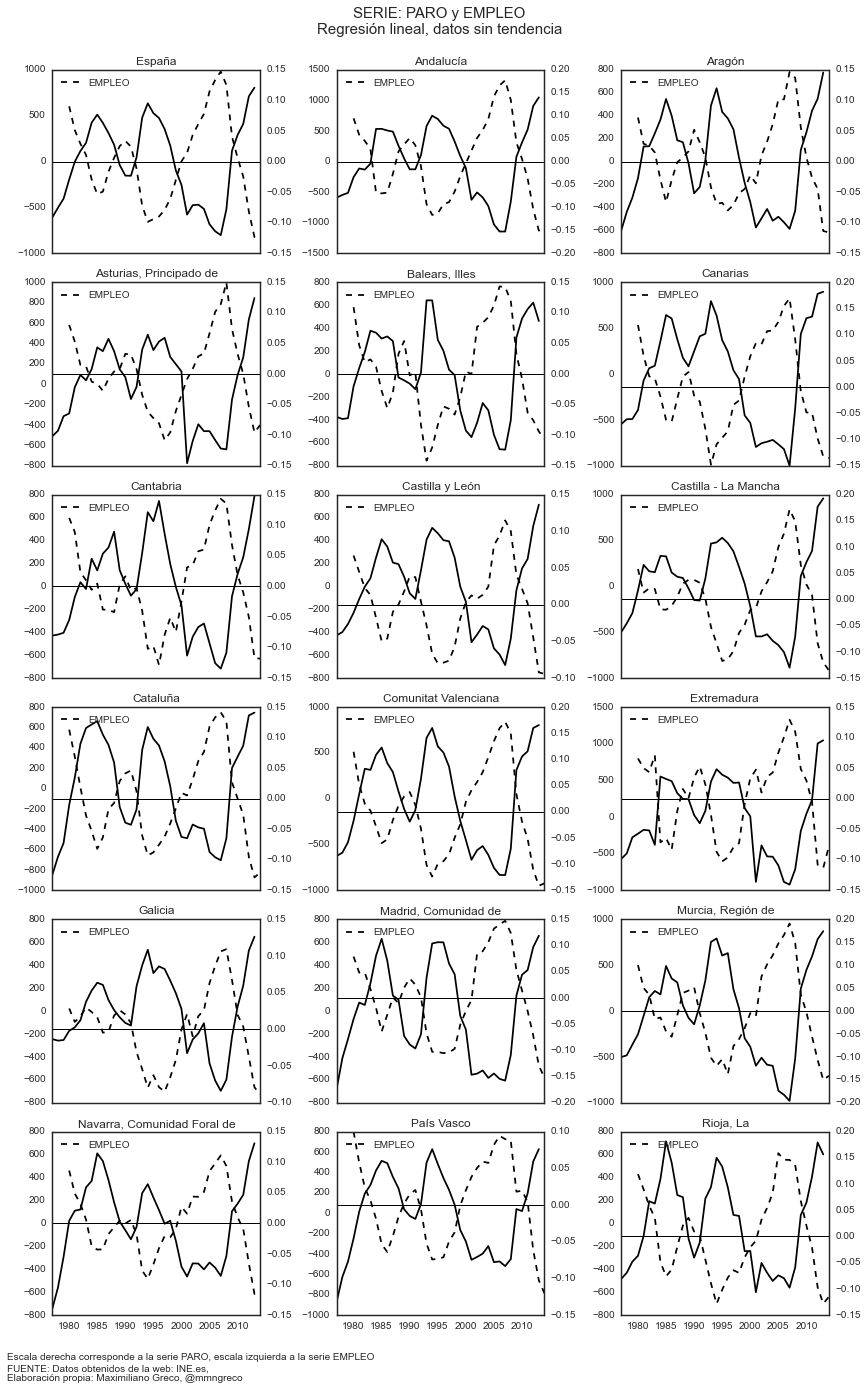

In [193]:
# PARAMETROS DEL GRÁFICO
id_x = 0
x = ['paro', 'empleo']
y = 'pib'
data = dwork
ttl = 'SERIE: %s y %s\nRegresión lineal, datos sin tendencia' % (x[0].upper(), x[1].upper())
file_name = 'serie_%s_%s_%s.png' % (x[0], x[1], nombre_xls[id_xls])
foot1 = 'Escala derecha corresponde a la serie PARO, escala izquierda a la serie EMPLEO\nFUENTE: Datos obtenidos de la web: INE.es, \nElaboración propia: Maximiliano Greco, @mmngreco' 
c = 'black'

######## 

fig = plt.figure(figsize=(12,18))

for i, reg in enumerate(regiones):
    ax = fig.add_subplot(len(regiones)/3, 3, i + 1)
    data[x[0]][reg].plot(ax=ax, label=x[0].upper(), color=c, sharex=True)
    data[x[1]][reg].plot(ax=ax, linestyle='--', label=x[1].upper(), secondary_y=True, color=c, sharex=True)
    plt.axhline(y=0, color='black', linewidth=1, axes=ax)
    plt.title(reg)
    plt.legend(loc='upper left')

plt.gcf().text(0, -0.03, "%s" % foot1, fontsize=10, transform=(1,1))
plt.tight_layout()
plt.suptitle(t=ttl, fontsize=15, x=0.5, y=1.03)
plt.savefig('imgs/%s' % file_name, bbox_inches='tight', dpi=200)

/Users/mmngreco/anaconda/envs/py3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


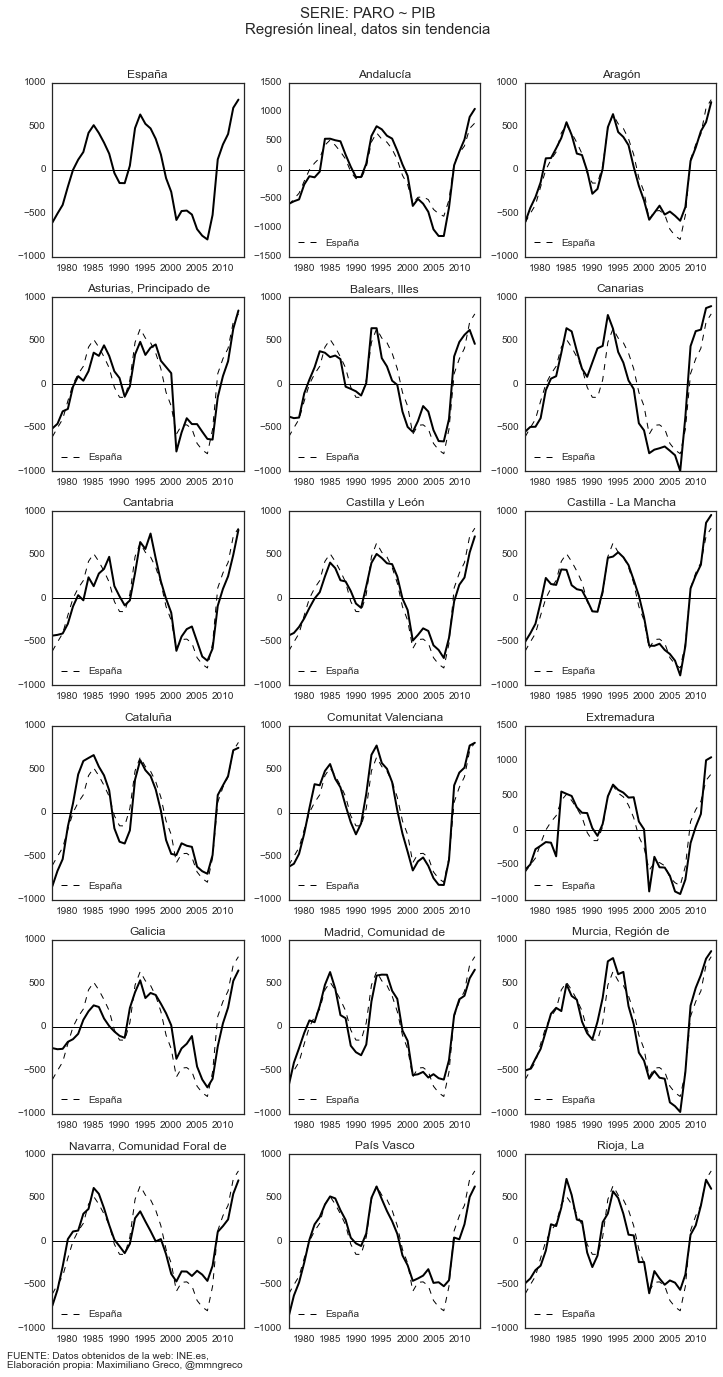

In [194]:
# PARAMETROS DEL GRÁFICO
id_x = 0
x = ['paro', 'empleo']
y = 'pib'
data = dwork
ttl = 'SERIE: %s ~ %s\nRegresión lineal, datos sin tendencia' % (x[id_x].upper(), y.upper())
file_name = 'serie_%s_%s.png' % (x[id_x], nombre_xls[id_xls])
c = 'black'
######## 

fig = plt.figure(figsize=(10,18))

for i, reg in enumerate(regiones):
    ax = fig.add_subplot(len(regiones)/3, 3, i + 1)
    if i > 0:
        data[x[id_x]]['España'].plot(ax=ax, linewidth=1, linestyle='--', color=c, label='España')
    else:
        pass
    data[x[id_x]][reg].plot(ax=ax, linewidth=2, color=c, label='')
    plt.axhline(y=0, color=c, linewidth=1)
    plt.title(reg)
    plt.legend(loc='lower left')
plt.gcf().text(0, -0.01, "%s" % foot, fontsize=10, transform=(1,1))
plt.tight_layout()
plt.suptitle(t=ttl, fontsize=15, x=0.5, y=1.04)
plt.savefig('imgs/%s' % file_name, bbox_inches='tight', dpi=200)

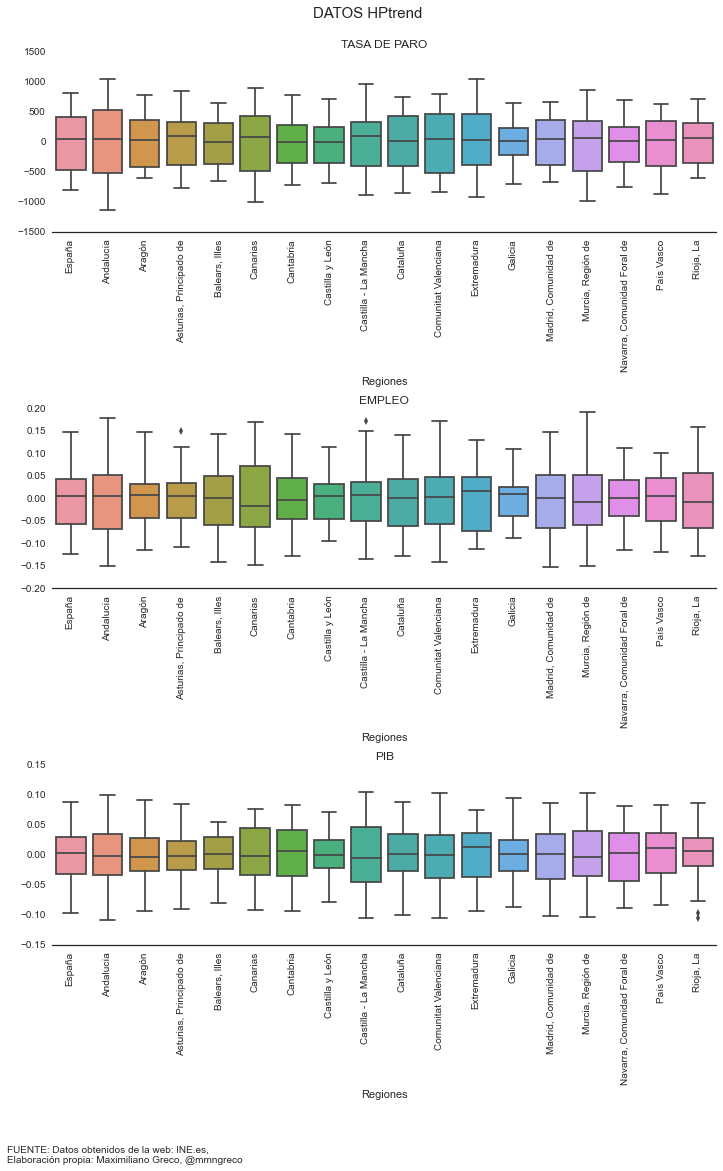

In [195]:
i = id_xls
data = dwork
ttl= 'DATOS %s' % nombre_xls[i]
file_name = 'box_plot_%s.png' % nombre_xls[i]

# con seaborn
fig = plt.figure(figsize=(10,15))
#sns.set(style='whitegrid')

g1 = sns.boxplot(data=data.paro, fliersize=5, width=.8, ax=fig.add_subplot(311))
g1.set_xticklabels(data.paro.columns, rotation=90)
g1.set_title('TASA DE PARO')

g2 = sns.boxplot(data=data.empleo, fliersize=5, width=.8, ax=fig.add_subplot(312))
g2.set_xticklabels(data.empleo.columns, rotation=90)
g2.set_title('EMPLEO')

g3 = sns.boxplot(data=data.pib, fliersize=5, width=.8, ax=fig.add_subplot(313))
g3.set_xticklabels(data.pib.columns, rotation=90)
g3.set_title('PIB')

sns.despine(left=True)

plt.suptitle(x=0.5, y=1.02, t=ttl, fontsize=15)
plt.gcf().text(0, -0.05, "%s" % foot, fontsize=10, transform=(1,1))
plt.tight_layout()

plt.savefig('imgs/%s' % file_name, bbox_inches='tight', dpi=150)


# CORRELACIÓN:

[Este análisis](#CORRELACIÓN:) nos dará una idea de como son, según los datos, las relaciones entre ambas variables, y su intensidad. En teoría, esperamos que la correlación entre la tasa de paro y el PIB sea __negativa__, es decir, cuanto más aumente PIB, el efecto esperado sobre la tasa de paro es que disminuya.

Veamos que sucede:

In [196]:
id_x = 1
x = ['paro', 'empleo']
y = 'pib'
dwork[x[id_x]].corrwith(dwork[y], axis=0).order(ascending=True)

Regiones
Balears, Illes                 0.473472
Extremadura                    0.553235
Rioja, La                      0.619246
Castilla y León                0.771174
Asturias, Principado de        0.816883
Cantabria                      0.825781
Castilla - La Mancha           0.865526
Aragón                         0.882908
Galicia                        0.888272
Madrid, Comunidad de           0.893396
Canarias                       0.894514
Navarra, Comunidad Foral de    0.911226
Andalucía                      0.941183
Cataluña                       0.947278
España                         0.953734
País Vasco                     0.957800
Murcia, Región de              0.964344
Comunitat Valenciana           0.964402
dtype: float64

Vemos que en general, se cumple lo que la teoría predice, pero ya podemos ver que tendremos algunos problemas dado que los efectos __no son muy intensos__. Destaca sobre todo __Extremadura__, que tiene un coeficiente de correlación muy próximo a cero.

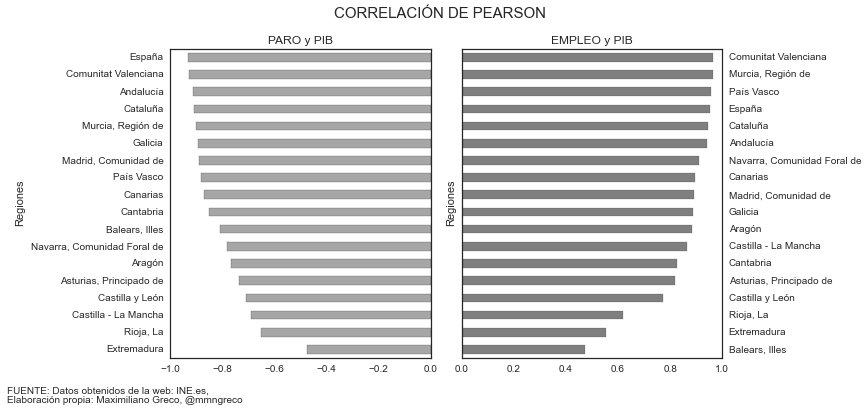

In [197]:
data = dwork
ttl = 'CORRELACIÓN DE PEARSON'
file_name = 'corr_pearson_%s.png' % nombre_xls[id_xls]
x = ['paro', 'empleo']
y = 'pib'

# ----------------------------

plt.figure(figsize=(12,5))

plt.subplot(121)
data[x[0]].corrwith(data[y], axis=0).order(ascending=False).plot(kind='barh', color='grey', alpha=0.7)
plt.gca().set_title('%s y %s' % (x[0].upper(), y.upper()))

plt.subplot(122)
data[x[1]].corrwith(data[y], axis=0).order(ascending=True).plot(kind='barh', color='black', alpha=0.5)
plt.gca().yaxis.tick_right()
plt.gca().set_title('%s y %s' % (x[1].upper(), y.upper()))

plt.suptitle('CORRELACIÓN DE PEARSON', fontsize=15, x=0.5, y=1.05)

plt.gcf().text(0, -0.05, "%s" % foot, fontsize=10, transform=(1,1))
plt.tight_layout()
plt.savefig('imgs/%s' % file_name, bbox_inches='tight', dpi=150)

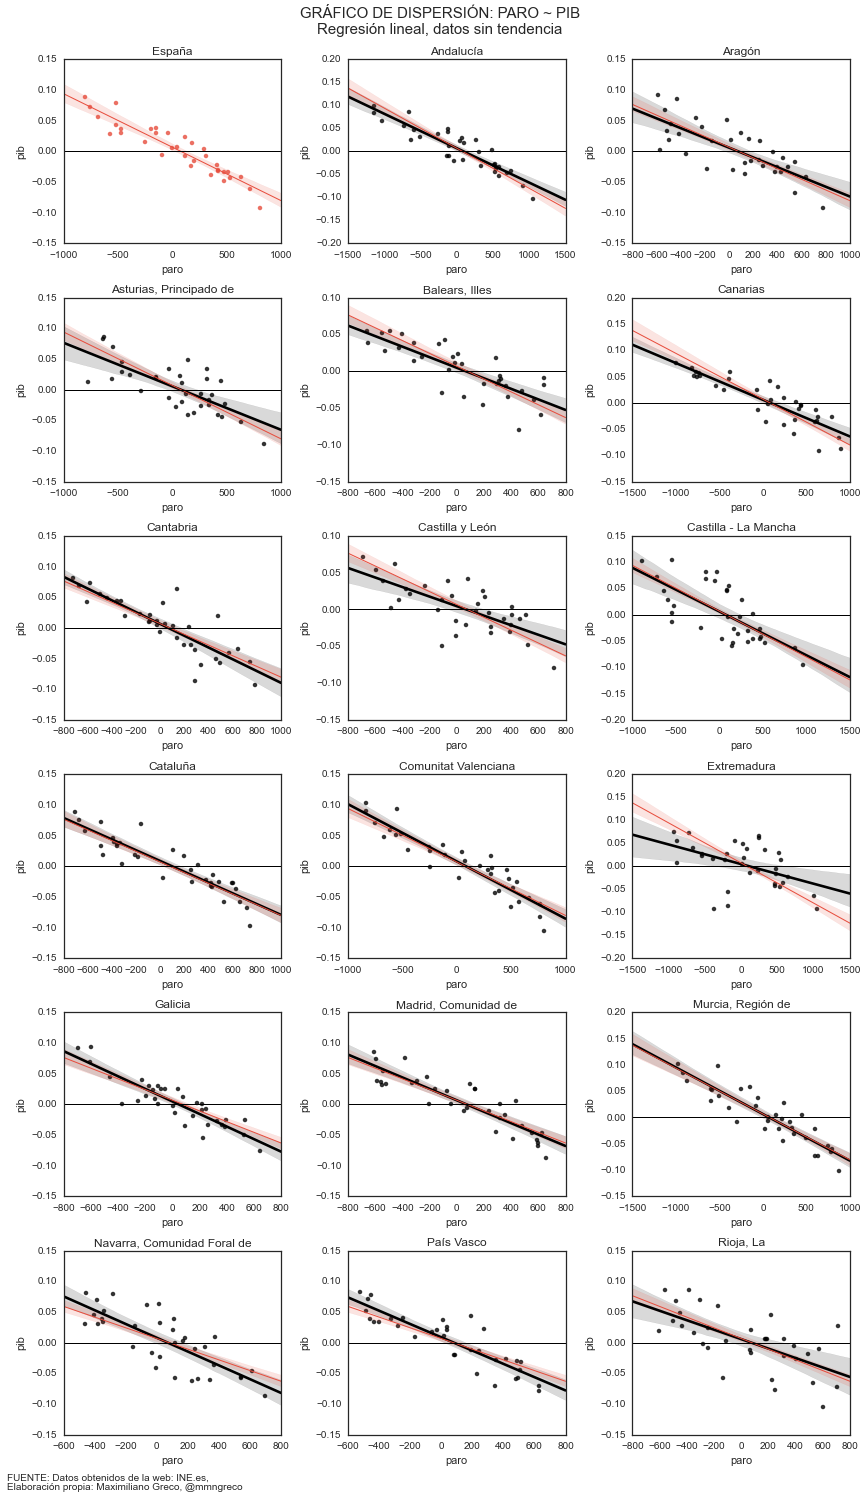

In [198]:
# PARAMETROS DEL GRÁFICO
id_x = 0
x = ['paro', 'empleo']
y = 'pib'
data = dwork
ttl = 'GRÁFICO DE DISPERSIÓN: %s ~ %s\nRegresión lineal, datos sin tendencia' % (x[id_x].upper(), y.upper())
file_name = 'dispersion_%s_%s.png' % (x[id_x], nombre_xls[id_xls])

######## 

fig = plt.figure(figsize=(12,20))

for i, reg in enumerate(regiones):
    if reg == 'España':
        ax = fig.add_subplot(len(regiones)/3, 3, i + 1)
        g = sns.regplot(y=data[y][reg], x=data[x[id_x]][reg], ax=ax, color="#e74c3c", line_kws={'linewidth': 1})
        plt.axhline(y=0, color='black', linewidth=1)

    else:
        ax = fig.add_subplot(len(regiones)/3, 3, i + 1)
        g = sns.regplot(y=data[y][reg], x=data[x[id_x]][reg], ax=ax, color='black')
        sns.regplot(y=data[y]['España'], 
                    x=data[x[id_x]]['España'], 
                    ax=ax, 
                    color="#e74c3c", 
                    scatter=False, 
                    line_kws={'linewidth': 1})
        plt.axhline(y=0, color='black', linewidth=1)
    g.set_xlabel(x[id_x])
    g.set_ylabel(y)
    g.set_title(reg)

plt.gcf().text(0, -0.01, "%s" % foot, fontsize=10, transform=(1,1))
plt.tight_layout()
plt.suptitle(t=ttl, fontsize=15, x=0.5, y=1.02)
plt.savefig('imgs/%s' % file_name, bbox_inches='tight', dpi=150)

# MODELO MCO: 

## TASA PARO:

### MODELO A ESTIMAR:
### $$ (y - y^*) = \beta_0 + \beta_1(u - u^*) $$

donde:

- __$y$__ = Tasa de crecimiento interanual.
- __$y^*$__ = Tasa de crecimiento natural.
- __$u$__ = Tasa de paro.
- __$u^*$__ = Tasa de paro natual.
- __$\beta_0$__ = Término Independiente.
- __$\beta_1$__ = Efecto de $(u-u^*)$ sobre $(y-y^*)$.


## UMBRAL DE CRECIMIENTO:

- PARO
- EMPLEO

El umbral de crecimiento de una economía, es la interpretación más util que nos dá el modelo de Okun. Nos dice cuanto tiene que crecer la economía para comenzar a crear empleo o reducir la tasa de paro.

__Se obtiene a partir del modelo de Okun:__

### $$ (y - y^*) = \beta_0 + \beta_1(u - u^*) $$

Tal y como está enunciado, el umbral de crecimiento lo obtenemos cuando $(u - u^*) = 0$, por tanto:

$$ (y - y^*) = \beta_0 + \beta_1(u - u^*) $$

$$ (y - y^*) = \beta_0 $$




# RESÚMEN:

In [199]:
# Fit and summarize OLS model

x = ['paro', 'empleo']
y = 'pib'
id_x = 0
s, p, m = estimar_mco(data, exogena=x[id_x], endogena=y, regiones=regiones)
resumen_mco(p, 1)

,$β_0$,$pv_{β_0}$,$β_1$,$pv_{β_1}$,$R^2$
Extremadura,0.004322,0.559740,-0.000043,4.644766e-03,0.224508
"Rioja, La",0.005714,0.364937,-0.000077,3.241917e-05,0.421782
Castilla - La Mancha,0.006043,0.384812,-0.000083,6.155684e-06,0.477028
Castilla y León,0.004483,0.284655,-0.000065,2.651220e-06,0.503110
"Asturias, Principado de",0.005353,0.254703,-0.000071,6.529971e-07,0.543779
Aragón,0.005955,0.209719,-0.000080,1.141877e-07,0.589941
"Navarra, Comunidad Foral de",0.007872,0.137258,-0.000113,4.771185e-08,0.611314
"Balears, Illes",0.004663,0.204403,-0.000072,7.898412e-09,0.652000
Cantabria,0.006326,0.143435,-0.000096,1.623810e-10,0.726167
Canarias,0.005622,0.158491,-0.000070,2.266678e-11,0.757579


# EXPORTAR:

In [200]:
# guardar_mco(sumrz_paro, 'modelos_u')

# guardar_mco(sumrz_empleo, 'modelos_l')

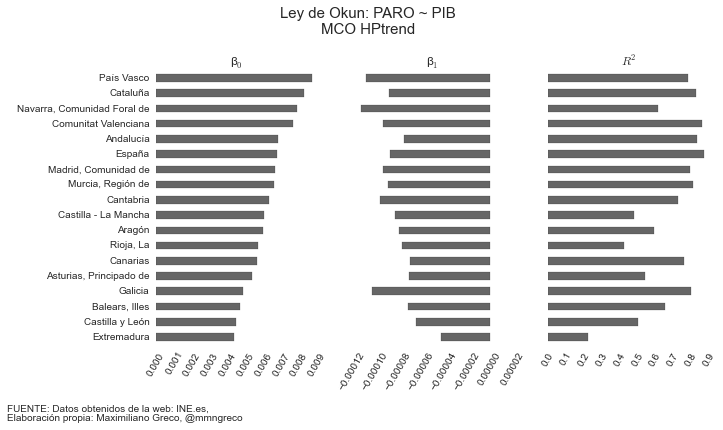

In [202]:
# PARAMETROS DEL GRÁFICO
id_x = 0
x = ['paro', 'empleo']
y = 'pib'

data = dwork.copy(deep=True)
s, p, m = estimar_mco(data, exogena=x[id_x], endogena=y, regiones=regiones)
data = resumen_mco(p, 0) 

fig = plt.figure(figsize=(10,5))
nombre_xls[id_xls]
ttl = 'Ley de Okun: %s ~ PIB\nMCO %s' % (x[id_x].upper(), nombre_xls[id_xls])
file_name = 'res_mco_%s_%s.png' % (x[id_x].upper(), nombre_xls[id_xls])
color = 'black'
alpha = 0.6
linestyle = '--'


id_c = 0
ordenar_por = data.columns[id_c]
data.sort(ordenar_por, ascending=True, inplace=True)

######## 


ax1 = plt.subplot(1,3,1)
data.b0.plot(kind='barh', title='β$_0$', color=color, alpha=alpha, sharey=True)
#data.b0.order(ascending=False).plot(kind='barh', title='β$_0$', color=color, alpha=alpha)
plt.xticks(rotation=60)
#plt.axvline(data.b0.T['España'], linestyle=linestyle)

ax2 = plt.subplot(1,3,2)
data.b1.plot(kind='barh', title='β$_1$', color=color, alpha=alpha, sharey=True)
#data.b1.order(ascending=False).plot(kind='barh', title='β$_1$', color=color, alpha=alpha)
#plt.axvline(data.b1.T['España'], linestyle=linestyle)
plt.xticks(rotation=60)

ax3 = plt.subplot(1,3,3)
data['R2'].plot(kind='barh', title='$R^2$', color=color, alpha=alpha, sharey=True)
#data['R2'].order(ascending=False).plot(kind='barh', title='$R^2$', color=color, alpha=alpha)
#plt.axvline(data['R2'].T['España'], linestyle=linestyle)
plt.xticks(rotation=60)

for ax in [ax1, ax2, ax3]:
    ax.spines["top"].set_visible(False)  
    ax.spines["bottom"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    ax.spines["left"].set_visible(False)  

    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

    ax.axes.get_xaxis().set_visible(True)
    ax.axes.get_yaxis().set_visible(True)

    ax.tick_params(axis='both',
                   which='both',
                   bottom='off',
                   top='off',
                   left='off',
                   labelbottom='on',
                   labelleft='on')

plt.gcf().text(0, -0.05, "%s" % foot, fontsize=10, transform=(1,1))
plt.suptitle(x=0.5, y=1.1, t=ttl, fontsize=15)
plt.tight_layout()

plt.savefig('imgs/%s' % file_name, bbox_inches='tight', dpi=150)

# OUTLIERS:
---
## nota1

Econtrados 4 outliers pasando el test de bonferroni, con datos de empleo de la serie HP.

### Castilla y León
1981    0.02278
Name: bonf(p), dtype: float64

---

### Comunitat Valenciana
1980    0.03059
Name: bonf(p), dtype: float64

---

### Extremadura
1983    0.049994
Name: bonf(p), dtype: float64

---

### Navarra, Comunidad Foral de
1990    0.040225
Name: bonf(p), dtype: float64

---



In [134]:
# MCO: TASA PARO VS PIB
x = ['paro', 'empleo']
id_x = 1
d = [mp, me]

outliers_index = dict()
print('## OUTLIERS EN %s' % x[id_x].upper())

for ca in regiones:
    outlier = d[id_x][ca].outlier_test()['bonf(p)']
    
    if (outlier < 0.05).any() > 0:
        print('###', ca)
        print(outlier[outlier < 0.05])
        print('\n---\n')
        outliers_index[ca] = outlier[outlier < 0.05].index[0]

## OUTLIERS EN EMPLEO
### Castilla y León
1981    0.02278
Name: bonf(p), dtype: float64

---

### Comunitat Valenciana
1980    0.03059
Name: bonf(p), dtype: float64

---

### Extremadura
1983    0.049994
Name: bonf(p), dtype: float64

---

### Navarra, Comunidad Foral de
1990    0.040225
Name: bonf(p), dtype: float64

---



## REESTIMAR:

In [137]:
d = dwork.copy(deep=True)
y = 'pib'
print('REESTIMANDO:', x[id_x], y)
for reg, year in outliers_index.items():
    d[x[id_x]][reg].loc[year] = nan
    print(year, d[x[id_x]][reg].loc[year])


s, p, m = estimar_mco(d, endogena=y, exogena=x[id_x], regiones=regiones)

REESTIMANDO: empleo pib
1980 nan
1990 nan
1981 nan
1983 nan


/Users/mmngreco/anaconda/envs/py3/lib/python3.4/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## RESÚMEN:

In [138]:
resumen_mco(p, 0)

,b0,pv_b0,b1,pv_b1,R2
"Balears, Illes",-1.024066e-13,1.000000,0.225049,4.068252e-03,0.224176
"Rioja, La",-9.902973e-14,1.000000,0.364211,7.305866e-05,0.383466
Extremadura,3.720299e-03,0.553017,0.457827,2.158712e-05,0.435784
"Asturias, Principado de",5.097702e-14,1.000000,0.543374,2.163486e-09,0.667298
Cantabria,-1.655091e-13,1.000000,0.536735,1.020701e-09,0.681914
Castilla y León,2.147027e-03,0.523667,0.528752,6.275807e-10,0.702310
Castilla - La Mancha,-1.126941e-13,1.000000,0.655455,1.944405e-11,0.749136
Aragón,2.963862e-13,1.000000,0.598241,2.266784e-12,0.779527
Galicia,-7.469112e-14,1.000000,0.685017,1.089789e-12,0.789027
"Madrid, Comunidad de",-4.209740e-15,1.000000,0.516047,5.224057e-13,0.798156


## EXPORTAR:

In [23]:
# MCO: PARO:
# guardar_mco(sumrz_paro_outlier, 'modelos_outlier_u')

# SERIES ESTACIONARIAS:
---
## MODELO:

## $$ (y - y^*) = \beta_0 + \beta_1(u - u^*) $$

donde:

- __$y$__ = Tasa de crecimiento interanual.
- __$y^*$__ = Tasa de crecimiento natural.
- __$u$__ = Tasa de paro.
- __$u^*$__ = Tasa de paro natual.
- __$\beta_0$__ = Término Independiente.
- __$\beta_1$__ = Efecto de $(u-u^*)$ sobre $(y-y^*)$.


- [DATOS](#SERIES-FILTRADAS:)

In [208]:
for i in range(5):
    il = i
    iy = i
    iu = i

    file_name = nombre_xls[i]
    dl = dempleo[il]
    dy = dpib[iy]
    du = dparo[iu]

    data = crear_df([dl, du, dy])

    x, y = ['paro', 'empleo'], 'pib'
    id_x = 0  # 0 = paro, 1 = empleo ---> exogena
    var = x[id_x]
    if i < 3:
        data['paro'] = data['paro'] / 100
    else:
        pass

#    data.to_excel('data_work/MCO/dmco_%s.xls' % file_name, encoding=UTF)
    s, p, m = estimar_mco(data, 
                          exogena=var, 
                          endogena=y, 
                          regiones=regiones)

    res_mco = resumen_mco(p, 0)

    print('Guardando hoja de excel nº', i),
    print('Nombre de la hoja excel:', file_name),
    print('Peor R2 =', res_mco['R2'].min())
    print('-----------------------')

    res_mco['sig_b0'] = res_mco['pv_b0'].apply(pvalue_sig_5)
    res_mco['sig_b1'] = res_mco['pv_b1'].apply(pvalue_sig_5)
    
#    res_mco.to_excel('data_work/MCO/%s/%s.xls' % (x[id_x], file_name), encoding=UTF)

NotImplementedError: Writing as Excel with a MultiIndex is not yet implemented.

## CONTRASTE DE RAÍZ UNITARIA: 

- __$H_0$__: Tiene raíz unitaria, 
- __$H_1$__: No tiene raíz unitaria

In [140]:
id_x = 1
x = ['paro', 'empleo']
y = 'pib'
rango = range(5)
rango = [4]
for i in rango:
    
    il = i
    iy = i
    iu = i
    
    dl = dempleo[il]
    dy = dpib[iy]
    du = dparo[iu]

    data = crear_df([dl, du, dy])

    print('HOJA: {:^30}'.format(nombre_xls[i]))
    print('=' * 40)
    for reg in regiones:
        try:
            pv = sm.tsa.stattools.adfuller(data[x[id_x]][reg].dropna(axis=0), regression='c', autolag='BIC')[1]
        except:
            continue

        if pv < 0.05:
            print('{:25}\t{:4.3f}\t***'.format(reg, pv))
        else:
            print('{:25}\t{:4.3f}\t'.format(reg, pv))
            
    print('-' * 40)

HOJA:            HPtrend            
España                   	0.032	***
Andalucía                	0.053	
Aragón                   	0.251	
Asturias, Principado de  	0.130	
Balears, Illes           	0.278	
Canarias                 	0.251	
Cantabria                	0.275	
Castilla y León          	0.037	***
Castilla - La Mancha     	0.208	
Cataluña                 	0.046	***
Comunitat Valenciana     	0.061	
Extremadura              	0.132	
Galicia                  	0.266	
Madrid, Comunidad de     	0.020	***
Murcia, Región de        	0.047	***
Navarra, Comunidad Foral de	0.204	
País Vasco               	0.268	
Rioja, La                	0.030	***
----------------------------------------


# FILTRO HP

In [42]:
#for i in range(5):
id_x = 1
x = ['paro', 'empleo']
y = 'pib'

i = 1
il = i
iy = i
iu = i

dl = dempleo[il]
dy = dpib[iy]
du = dparo[iu]

data = crear_df([dl, du, dy])


print('HOJA %s' % nombre_xls[i])

d = data[x[id_x]]
d = data[y]
d = d.dropna(axis=0)
ciclo, tendencia = sm.tsa.filters.hpfilter(d)
dy = ciclo

HOJA log-tasa


In [43]:
s, p, m = estimar_mco(crear_df([dl,dy], keys=['empleo', 'pib']), endogena='pib', exogena='empleo', regiones=regiones)
resumen_mco(p, 0)

,b0,pv_b0,b1,pv_b1,R2
"Balears, Illes",24.596890,4.531942e-02,-4.210539,4.787101e-02,0.116827
"Madrid, Comunidad de",47.069656,1.396661e-02,-6.134001,1.464615e-02,0.172287
Castilla - La Mancha,62.371659,9.770804e-03,-9.700690,1.011700e-02,0.189326
"Murcia, Región de",46.238807,9.421115e-03,-7.681692,9.907035e-03,0.190286
Canarias,57.437861,5.480148e-03,-8.998336,5.771206e-03,0.214794
"Rioja, La",40.432278,5.035275e-03,-8.636154,5.358187e-03,0.218125
Aragón,71.856727,4.597688e-03,-11.652322,4.789028e-03,0.223145
"Navarra, Comunidad Foral de",39.263134,3.333993e-03,-7.243038,3.655832e-03,0.235123
Andalucía,90.777007,2.186378e-03,-11.789917,2.281448e-03,0.255723
España,104.322945,2.053232e-03,-10.846159,2.128699e-03,0.258716


# FILTRO QT:

In [146]:
id_xls = 0
last_obs = 2004

id_v = 1  #    0       1       2 
variables = ['pib', 'paro', 'empleo']

var = variables[id_v]

data = crear_df([dempleo[id_xls], dparo[id_xls], dpib[id_xls]])

d = data[var]# .loc[:last_obs]
d.dropna(axis=0, inplace=True)

file_name= 'qt_%s_%s' % (var, nombre_xls[id_xls])
globals()['qt_%s' % var] = sm.tsa.tsatools.detrend(d, order=2, axis=0)
df = globals()['qt_%s' % var]

globals()['qt_%s' % var] = DataFrame(v, index=d.index, columns=d.columns)
print('qt_%s' % var)

df = globals()['qt_%s' % var

df.to_excel('data_work/filtrado/%s.xls' % file_name, encoding=UTF)
df.head()

qt_paro


/Users/mmngreco/anaconda/envs/py3/lib/python3.4/site-packages/IPython/kernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Regiones,España,Andalucía,Aragón,"Asturias, Principado de","Balears, Illes",Canarias,Cantabria,Castilla y León,Castilla - La Mancha,Cataluña,Comunitat Valenciana,Extremadura,Galicia,"Madrid, Comunidad de","Murcia, Región de","Navarra, Comunidad Foral de",País Vasco,"Rioja, La"
1977,-7.024885,-6.323424,-7.562322,-5.142244,-5.864075,-8.067891,-3.674263,-4.185637,-6.823133,-10.223321,-7.878956,-5.620497,-1.880601,-7.752795,-6.471040,-9.128147,-8.187439,-6.209227
1978,-5.763980,-5.806435,-5.561944,-4.611030,-5.565304,-6.953261,-3.744752,-3.931743,-5.455224,-8.024361,-7.155037,-4.912608,-2.163239,-4.889675,-5.972239,-6.875420,-5.887356,-5.349273
1979,-4.544948,-5.360875,-3.965698,-3.146644,-5.031556,-6.366557,-3.696929,-3.228007,-3.951679,-6.244483,-5.637404,-2.713926,-2.227828,-2.973858,-4.485409,-3.798328,-4.408507,-4.064200
1980,-2.215288,-2.631743,-1.918583,-2.806583,-1.805332,-4.822780,-2.640794,-2.209429,-1.102496,-2.086189,-2.923559,-2.179450,-1.504367,-0.975344,-3.038050,-0.256870,-2.115894,-3.241507
1981,-0.027501,-1.036540,1.164400,-0.148348,0.188368,-1.071930,-0.658848,-0.953508,2.042322,1.000522,0.356500,-1.574182,-1.242857,0.695867,-0.712662,0.993954,0.552983,-1.213695


In [147]:
s, b, m = estimar_mco(crear_df([qt_paro / 100, qt_pib], keys=['paro', 'pib']), 
                      endogena='pib', 
                      exogena='paro', 
                      regiones=regiones)


In [148]:
resumen_mco(b, 0)

,b0,pv_b0,b1,pv_b1,R2
Extremadura,0.518947,0.478587,-58.333576,2.074219e-05,0.437142
Castilla - La Mancha,0.897782,0.354939,-93.286400,2.004125e-05,0.438308
"Rioja, La",0.751431,0.369868,-89.640014,1.985886e-05,0.438618
Aragón,0.767572,0.323380,-83.072387,1.660539e-05,0.444651
"Navarra, Comunidad Foral de",1.022387,0.240566,-111.128412,1.188709e-05,0.455761
"Asturias, Principado de",0.577022,0.341391,-74.666235,1.113665e-06,0.528674
Castilla y León,0.473693,0.340190,-69.098020,7.453787e-07,0.540079
Cataluña,1.004832,0.180888,-88.413607,2.842690e-07,0.566388
"Madrid, Comunidad de",0.940382,0.212105,-107.106370,7.180557e-08,0.601440
País Vasco,0.964132,0.156420,-106.664377,2.437256e-08,0.627025


# EVOLUCIÓN:

In [54]:
data = crear_df([dl, du, dy])

fin = max(data.index)
hasta = 1990
x = 'paro'
y = 'pib'

dl_b0_evolucion = DataFrame(columns=regiones)
dl_b1_evolucion = DataFrame(columns=regiones)
dl_umbral_evolucion = DataFrame(columns=regiones)
# task crear_df(par)
while hasta <= fin:
    s, p, m = estimar_mco(data.loc[:hasta], 
                          endogena=y, 
                          exogena=x, 
                          regiones=regiones)

    dl_b0_evolucion.loc[hasta] =  resumen_mco(p, 0).b0.T
    dl_b1_evolucion.loc[hasta] =  resumen_mco(p, 0).b1.T

    hasta += 1

evolucion_okun = crear_df([dl_b0_evolucion, dl_b1_evolucion, dl_umbral_evolucion], keys=['b0', 'b1'])
evolucion_okun.head()

/Users/mmngreco/anaconda/envs/py3/lib/python3.4/site-packages/scipy/stats/stats.py:1277: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))
/Users/mmngreco/anaconda/envs/py3/lib/python3.4/site-packages/scipy/stats/stats.py:1277: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))
/Users/mmngreco/anaconda/envs/py3/lib/python3.4/site-packages/scipy/stats/stats.py:1277: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))
/Users/mmngreco/anaconda/envs/py3/lib/python3.4/site-packages/scipy/stats/stats.py:1277: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))
/Users/mmngreco/anaconda/envs/py3/lib/python3.4/site-packages/scipy/stats/stats.py:1277: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))
/Users/mmngreco/anaconda/envs/py3/lib/python3

Variables        b0                                              \
Regiones     España Andalucía    Aragón Asturias, Principado de   
1990       0.016851  0.008347  0.015132               -0.004234   
1991       0.016437  0.011444  0.015805                0.000233   
1992       0.016091  0.012471  0.016221                0.003763   
1993       0.016093  0.012346  0.016259                0.003114   
1994       0.015956  0.012362  0.016263                0.003262   

Variables                                                     \
Regiones  Balears, Illes  Canarias Cantabria Castilla y León   
1990           -0.002821  0.019948  0.009246        0.002268   
1991            0.002218  0.020575  0.008653        0.003500   
1992            0.004420  0.021207  0.008073        0.003279   
1993            0.003377  0.019653  0.007186        0.003235   
1994            0.003140  0.019586  0.007008        0.003257   

Variables                                                                  \
Regiones  Castilla - La Mancha  Cataluña Comunitat Valenciana Extremadura   
1990                  0.040014  0.019185             0.012667   -0.012109   
1991                  0.036746  0.016141             0.014248   -0.004307   
1992                  0.039564  0.014131             0.014458   -0.001681   
1993                  0.037639  0.013987             0.014557   -0.003316   
1994                  0.036880  0.014326             0.014771   -0.004209   

Variables                                                   \
Regiones    Galicia Madrid, Comunidad de Murcia, Región de   
1990       0.004746             0.017310          0.020977   
1991       0.003535             0.016001          0.019830   
1992       0.004912             0.012834          0.019942   
1993       0.005213             0.010770          0.019067   
1994       0.005310             0.010222          0.018712   

Variables                                                         b1  \
Regiones  Navarra, Comunidad Foral de País Vasco Rioja, La    España   
1990                         0.045666   0.027416 -0.009277 -0.010585   
1991                         0.037516   0.025000 -0.002125 -0.010459   
1992                         0.029377   0.021326  0.001814 -0.010414   
1993                         0.026522   0.021581  0.002786 -0.010402   
1994                         0.025384   0.022341  0.002989 -0.010029   

Variables                                                             \
Regiones  Andalucía    Aragón Asturias, Principado de Balears, Illes   
1990      -0.006027 -0.008840                0.003980      -0.004839   
1991      -0.006683 -0.009067                0.002401      -0.006704   
1992      -0.006714 -0.009133                0.001540      -0.007186   
1993      -0.006969 -0.009006                0.000611      -0.005011   
1994      -0.007099 -0.009021               -0.000766      -0.004515   

Variables                                                                     \
Regiones   Canarias Cantabria Castilla y León Castilla - La Mancha  Cataluña   
1990      -0.011660 -0.007522       -0.000991            -0.030263 -0.010212   
1991      -0.011317 -0.007343       -0.001447            -0.028591 -0.009544   
1992      -0.010840 -0.007212       -0.001484            -0.028745 -0.009172   
1993      -0.009269 -0.008014       -0.001769            -0.023295 -0.009199   
1994      -0.008980 -0.007422       -0.001888            -0.021338 -0.008934   

Variables                                                                  \
Regiones  Comunitat Valenciana Extremadura   Galicia Madrid, Comunidad de   
1990                 -0.007613    0.010235 -0.013051            -0.008561   
1991                 -0.007993    0.008930 -0.012288            -0.008128   
1992                 -0.007970    0.008858 -0.010711            -0.007301   
1993                 -0.008514    0.007578 -0.009728            -0.007931   
1994                 -0.008946    0.005414 -0.008155            -0.008685

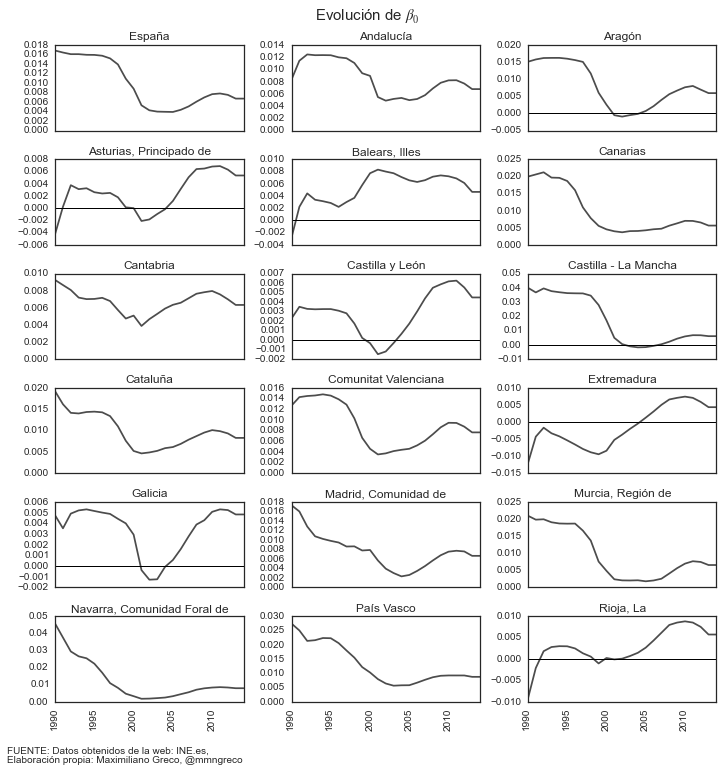

In [143]:
fig = plt.figure(figsize=(10,10))
p = 'b0'
ttl= 'Evolución de $β_%s$' % p[-1]
file_name = 'evolucion_%s.png' % p

for i, reg in enumerate(regiones):
    ax = fig.add_subplot(6,3,i+1)
    plt.axhline(y=0, color='black', linewidth=1)
    evolucion_okun[p][reg].plot(ax=ax, label=reg, sharex=True, color='black', alpha=0.7)
    plt.title(reg)
    plt.xticks(evolucion_okun.index[::5], evolucion_okun.index[::5], rotation=90)
    plt.xlim(evolucion_okun.index.min(), evolucion_okun.index.max())

plt.gcf().text(0, -0.03, "%s" % foot, fontsize=10, transform=(1,1))
plt.suptitle(x=0.5, y=1.02, t=ttl, fontsize=15)
plt.tight_layout()
plt.savefig('imgs/%s' % file_name, bbox_inches='tight', dpi=150)

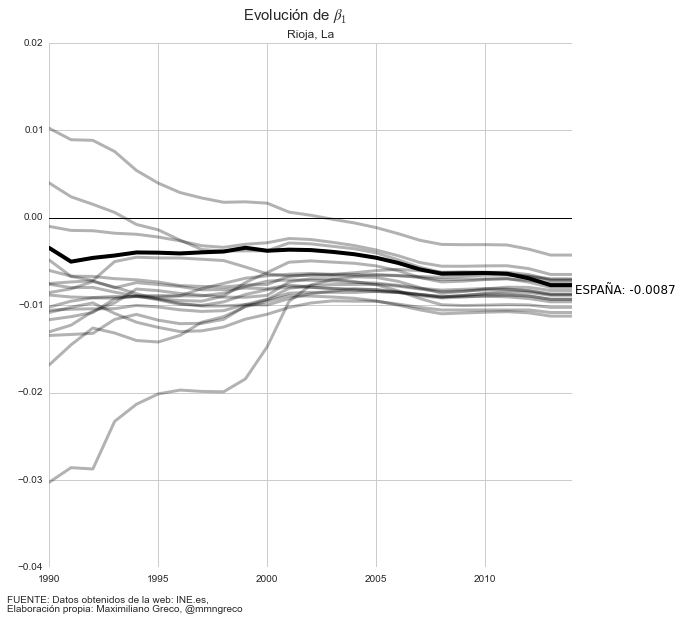

In [159]:
fig = plt.figure(figsize=(8,8), dpi=200)
p = 'b1'
ttl= 'Evolución de $β_%s$' % p[-1]
file_name = 'evolucion_%s_todas.png' % p
c = '#' + '000000'
c1 = '#' + '000000'
for i, reg in enumerate(regiones):
    ax = fig.add_subplot(111)
    plt.axhline(y=0, color='black', linewidth=1)
    evolucion_okun[p][reg].plot(ax=ax, label=reg, alpha=0.3, linewidth=3, color=c1)
    plt.title(reg)
evolucion_okun[p][reg].plot(ax=ax, label=reg, alpha=1, color=c, linewidth=4)

plt.xticks(evolucion_okun.index[::5])
plt.xlim(evolucion_okun.index.min(), evolucion_okun.index.max())

ax.spines["top"].set_visible(False)  
ax.spines["bottom"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.spines["left"].set_visible(False)  
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

ax.axes.get_xaxis().set_visible(True)
ax.axes.get_yaxis().set_visible(True)

ax.tick_params(axis='both',
               which='both',
               bottom='off',
               top='off',
               left='off',
               labelbottom='on',
               labelleft='on')

plt.text(2014.1, 
         evolucion_okun[p]['España'].values[-1], 
         'ESPAÑA: {:.4f}'.format(evolucion_okun[p]['España'].values[-1]),
         fontsize=12,
         family='bold',
         color=c)



plt.gcf().text(0, 
               -0.03, 
               "%s" % foot, 
               fontsize=10, 
               transform=(1,1))

plt.suptitle(x=0.5, y=1.02, t=ttl, fontsize=15)

plt.tight_layout()
plt.savefig('imgs/%s' % file_name, bbox_inches='tight', dpi=200)


# BIBLIOGRAFÍA:

- [Estadisticas Robustas](link1)
- [Correlación de Pearson](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient)
- [Ley de Okun](https://es.wikipedia.org/wiki/Ley_de_Okun)
- [Okun's Law](https://en.wikipedia.org/wiki/Okun%27s_law)
- [How useful is Okun's Law](https://www.kansascityfed.org/publicat/econrev/pdf/4q07knotek.pdf)
- [Interpreting Deviations from Okun’s Law](http://www.frbsf.org/economic-research/publications/economic-letter/2014/april/okun-law-deviation-unemployment-recession/)
- [Do Forecasters Believe in Okun’s Law? An Assessment of Unemployment and Output Forecasts](https://www.imf.org/external/pubs/ft/wp/2014/wp1424.pdf)
- [Criterio de Outliers](https://es.wikipedia.org/wiki/Valor_at%C3%ADpico)


[link1]:https://en.wikipedia.org/wiki/Robust_statistics#Definition

# TEORÍA

- [Ley de Okun](https://es.wikipedia.org/wiki/Ley_de_Okun)
- [Okun's Law](https://en.wikipedia.org/wiki/Okun%27s_law)
- [How useful is Okun's Law](https://www.kansascityfed.org/publicat/econrev/pdf/4q07knotek.pdf)
- [Interpreting Deviations from Okun’s Law](http://www.frbsf.org/economic-research/publications/economic-letter/2014/april/okun-law-deviation-unemployment-recession/)
- [Do Forecasters Believe in Okun’s Law? An Assessment of Unemployment and Output Forecasts](https://www.imf.org/external/pubs/ft/wp/2014/wp1424.pdf)


# Apéndice:

# Markdown Sintaxis:
- [Footnote](http://rephrase.net/box/word/footnotes/syntax/)
- [Sintaxis, guía](http://daringfireball.net/projects/markdown/syntax#link)

![](http://cdn.churchm.ag/wp-content/uploads/2014/01/markdown-cheatsheet.png)

# REGRESIÓN:

Método de estimación:
- MCO

## Statsmodels:
- [Get Started](http://statsmodels.sourceforge.net/devel/gettingstarted.html)
- [Regression](http://statsmodels.sourceforge.net/devel/regression.html)
- [QT-filter](http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.tsatools.detrend.html?highlight=trend#statsmodels.tsa.tsatools.detrend)
- [HP-filter](http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/tsa_filters.html?highlight=trend)

## Linear Regresion
- Linear Regression: [link](http://connor-johnson.com/2014/02/18/linear-regression-with-python/)
- HP filter: [link](http://link.springer.com/article/10.1007%2FBF01205950)
- Patsy Formula: [link](https://patsy.readthedocs.org/en/latest/formulas.html)

# CORRELACIÓN:

## __Coeficiente de correlación de Pearson __:
_[Wikipedia, la enciclopedia libre](https://es.wikipedia.org/wiki/Correlaci%C3%B3n)_

En estadística, el coeficiente de correlación de Pearson es una medida de la relación lineal entre dos variables aleatorias cuantitativas. A diferencia de la covarianza, la correlación de Pearson es independiente de la escala de medida de las variables.

De manera menos formal, podemos definir el coeficiente de correlación de Pearson como un índice que puede utilizarse para medir el grado de relación de dos variables siempre y cuando ambas sean cuantitativas.


El coeficiente de correlación de Pearson se simboliza con la letra $\rho_{x,y}$, siendo la expresión que nos permite calcularlo:

## $$\rho_{X,Y}={\sigma_{XY} \over \sigma_X \sigma_Y} ={E[(X-\mu_X)(Y-\mu_Y)] \over \sigma_X\sigma_Y}$$

Donde:

- $\sigma_{XY}$ es la covarianza de (X,Y)
- $\sigma_{X}$ es la desviación típica de la variable X
- $\sigma_{Y}$ es la desviación típica de la variable Y

## Para una muestra:

## $$r = r_{xy} =\frac{\sum ^n _{i=1}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum ^n _{i=1}(x_i - \bar{x})^2} \sqrt{\sum ^n _{i=1}(y_i - \bar{y})^2}}$$


## EJEMPLOS DE CORRELACIONES

![corr2_img](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d4/Correlation_examples2.svg/506px-Correlation_examples2.svg.png)

# Test de Jarque-Bera

En estadística, el test de Jarque-Bera es una prueba de bondad de ajuste acerca de si una muestra de datos tiene la asimetría y la curtosis de una distribución normal. El test recibe el nombre de Carlos Jarque y Anil K. Bera.

El test estadístico JB se define como:


$$JB = \frac{n-k+1}{6} \left( S^2 + \frac14 (C-3)^2 \right)$$
  
donde n es el número de observaciones (o grados de libertad en general); S es la asimetría de la muestra, C la curtosis de la muestra y k el número de regresores:


$S = \frac{ \hat{\mu}_3 }{ \hat{\sigma}^3 }$
$= \frac{\frac1n \sum_{i=1}^n (x_i-\bar{x})^3} {\left(\frac1n \sum_{i=1}^n (x_i-\bar{x})^2 \right)^{3/2}}$

$ C = \frac{ \hat{\mu}_4 }{ \hat{\sigma}^4 }$
$    = \frac{\frac1n \sum_{i=1}^n (x_i-\bar{x})^4} {\left(\frac1n \sum_{i=1}^n (x_i-\bar{x})^2 \right)^{2}} $

donde $\hat{\mu}_3$ y $\hat{\mu}_4$ son las estimaciones de los momentos centrales tercer y cuarto, respectivamente, $\bar{x}$ es la media de la muestra y $\hat{\sigma}^2$ es la estimación del segundo momento central, la varianza.

El estadístico de Jarque-Bera se distribuye asintóticamente como una distribución __chi cuadrado con dos grados de libertad__ y puede usarse para probar la __hipótesis nula__ de que los datos pertenecen a una distribución normal. La hipótesis nula es una __hipótesis conjunta__ de que la asimetría y la curtosis son nulas.



# Test de Breusch-Pagan

En estadística, el test de Breusch-Pagan se utiliza para determinar la heterocedasticidad en un modelo de regresión lineal. Analiza si la varianza estimada de los residuos de una regresión dependen de los valores de las variables independientes.

Supongamos que estimamos el siguiente modelo:


$y = \beta_0 + \beta_1 x + u$

y obtenemos un conjunto de valores para $\hat{u}$, los residuos. Con las restricciones de los Mínimos Cuadrados Ordinarios la media es 0, de modo que dada la suposición de que la varianza no depende de las variables independientes, la estimación de la varianza se puede obtener a partir de la media de los valores al cuadrado. Si la suposición no fuera correcta, podría ocurrir que la varianza estuviera relacionada linealmente con las variables independientes. Ese modelo se puede examinar haciendo una regresión de los residuos al cuadrado respecto de las variables independientes, empleando una ecuación de la forma:


$\hat{u}^2 = \gamma_0 + \gamma_1 x + v$

Esta es la base del test. Si el test-F confirma que las variables independientes son significativas, entonces se puede rechazar la __hipótesis nula__ de homocedasticidad.

# Estadístico de Durbin-Watson

En estadística, el estadístico de Durbin-Watson, desarrollado por el reputado economista Watson, es una estadística de prueba que se utiliza para detectar la presencia de autocorrelación (una relación entre los valores separados el uno del otro por un intervalo de tiempo dado) en los residuos (errores de predicción) de un análisis de la regresión. Lleva el nombre de James Durbin y Geoffrey Watson. La pequeña muestra de la distribución de esta relación se deriva de John von Neumann (von Neumann, 1941). Durbin y Watson (1950, 1951) aplicaron esta estadística para los residuales de mínimos cuadrados, y desarrollaron pruebas para la hipótesis nula de que los errores están correlacionados en serie frente a la alternativa de que siguen un proceso de primer orden autorregresivo. Más tarde, John Denis Sargan y Alok Bhargava desarrollaron varias pruebas estadísticas del tipo Neumann-Durbin-Watson von para la hipótesis nula de que los errores en un modelo de regresión siguen un proceso con una raíz unitaria contra la hipótesis alternativa de que los errores siguen un proceso estacionario de primer orden autorregresivo (Sargan y Bhargava, 1983).

## Cálculo e interpretación del estadístico de Durbin-Watson

Si et es el residual asociado a la observación en el tiempo t, entonces la prueba estadística es:

$d = {\sum_{t=2}^T (e_t - e_{t-1})^2 \over {\sum_{t=1}^T e_t^2}}$

Donde T es el número de observaciones. Puesto que d es aproximadamente igual a 2(1 − r), donde r es la autocorrelación de la muestra de los residuos,1 d = 2 indica que no hay autocorrelación. El valor de d siempre está entre -1 y 1,5. Si la estadística de Durbin-Watson es sustancialmente menor que 0,5, hay evidencia de correlación serial positiva. Como regla general, si Durbin-Watson es inferior a 1,0 aunque lo óptimos es que sea menor que 0, puede ser causa de alarma. Los valores pequeños de d indican los términos de error sucesivos son, en promedio, cerca del valor de los otros, o correlacionados positivamente. Si d> 2, los términos de error sucesivas son, en promedio, muy diferente en valor el uno del otro, es decir, correlacionada negativamente. En las regresiones, esto puede implicar una subestimación del nivel de significación estadística.

Para probar la __autocorrelación positiva__ en importancia α, la estadística de prueba d se compara con los valores críticos inferiores y superiores (dL,α and dU,α):

- Si d < dL,α, existe evidencia estadística de que los términos de error se autocorrelacionados positivamente.
- Si d > dU,α, no hay evidencia estadística de que los términos de error se autocorrelacionados positivamente.
- Si dL,α < d < dU,α, la prueba no es concluyente.

Correlación serial positiva es la correlación en serie en la que un error positivo para una observación aumenta las posibilidades de un error positivo para otra observación.

Para probar la autocorrelación negativa en significación α, la estadística de prueba (4 - d) se compara a bajar y los valores críticos de nivel superior (dL,α and dU,α):

- Si (4 − d) < dL,α, existe evidencia estadística de que los términos de error se autocorrelacionados negativamente.
- Si (4 − d) > dU,α, no hay evidencia estadística de que los términos de error se autocorrelacionados negativamente.
- Si dL,α < (4 − d) < dU,α, la prueba no es concluyente.

Correlación serial negativa implica que un error positivo para una observación aumenta la probabilidad de un error negativo para otra observación y un error negativo para uno aumenta las posibilidades de un error positivo para otra observación.

Los valores críticos, dL,α y dU,α, variar según el nivel de significación (α), el número de observaciones, y el número de predictores en la ecuación de regresión. Su derivación es compleja-los estadísticos suelen obtener a partir de los apéndices de textos estadísticos.

# Python

- [format](https://mkaz.com/2012/10/10/python-string-format/)

In [71]:
!open imgs

In [9]:
!subl3 .

In [32]:
def crea_link_md(texto, *texto_enlace):
    '''
    Crea enlace local con formato markdown para un string, o lista de string.
    '''
    if len(texto_enlace) > 0:
        texto_enlace = texto_enlace[0]
        if isinstance(texto, str):
            t = texto.replace(' ', '-')
            link = '[{}](#{})'.format(texto_enlace, t)
            print(t)
            print(link)
    #        return t, link
        elif isinstance(texto, list) and len(texto) == len(texto_enlace):
            ret = dict()
            for i, t in enumerate(texto):
                link = '[{}](#{})'.format(texto_enlace[i], t.replace(' ', '-'))
                ret[t] = link
            for k, v in ret.items():
                print(k)
                print(v)
    #        return ret
        else:
            print(len(texto) == len(texto_enlace), '{} != {}\n{}\t{}'.format(len(texto), len(texto_enlace), texto, texto_enlace))
    else:

        if isinstance(texto, str):
            t = texto.replace(' ', '-')
            link = '[](#{})'.format(t)
            print(t)
            print(link)
    #        return t, link
        elif isinstance(texto, list):
            ret = dict()
            for t in texto:
                link = '[](#{})'.format(t.replace(' ', '-'))
                ret[t] = link
            for k, v in ret.items():
                print(k)
                print(v)
    #        return ret




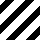
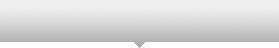
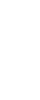
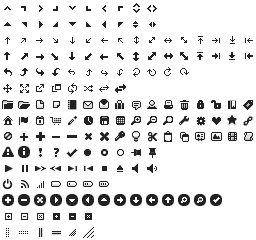
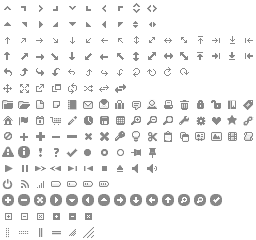
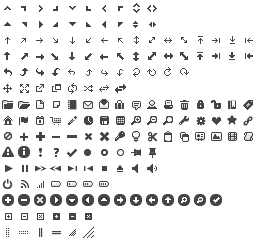
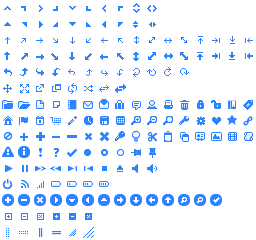
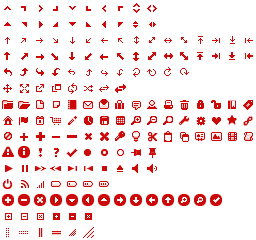
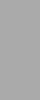
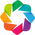
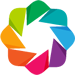
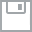
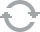
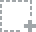
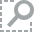
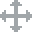
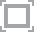
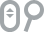

/Users/mmngreco/anaconda/envs/py3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [138]:
import bokeh.plotting as bkh
from bokeh import mpl

bkh.output_notebook()

ppl.plot(dwork.empleo, linewidth=3)
plt.xticks(dwork.index)
plt.legend(loc='upper left')
bkh.show(mpl.to_bokeh())

http://bokeh.pydata.org/en/latest/docs/reference/charts.html%23bokeh-charts